# Minimal Lasagne Demo (multilayer perceptron)
In this script we build a small multilayer perceptron with two hidden layers having 500 and 50 neurons each for classifying the MNIST database of handwritten digits.  


## Loading the data
While the original dataset has 70'000 examples of hand written digits (see below for loading) we restrict us here to the first 4000 digits so that an interactive session is possible. The subset of the first 4000 MNIST examples is provided in the repository for convenience. 

### Data-Format
For Lasagne all images must be provided in a 4-dimensional array X with the following dimensions (number of images, number of colors, x, y) and the labels in a vector y of same size. So X[1,0,1,2] would be the image number 1, the color channel 0 and the pixel x = 1 and y=2.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot

import cPickle as pickle
import gzip
with gzip.open('mnist_4000.pkl.gz', 'rb') as f:
    (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])
X.shape, y.shape, PIXELS

((4000, 1, 28, 28), (4000,), 28)

In [2]:
X[0,0,15,16] 

1.0584806

In [3]:
#from create_mnist import load_data_2d
#X,y,PIXELS = load_data_2d('/home/dueo/dl-playground/data/mnist.pkl.gz')
#X.shape, y

### Normalization of the data
The data is normalized so that each pixel has mean 0 and standard deviation close to 1 (calculated over all images). This has been done with the following code (the 0th axis is along the images): 
```
    Xmean = X.mean(axis = 0)
    XStd = np.sqrt(X.var(axis=0))
    X = (X-Xmean)/(XStd + 0.01)
```
Note that with this normalization the mean values of all pixels of a single image need not be 0.


In [4]:
np.mean(X[0,0,:,:]),np.mean(X[:,0,1,1]),np.mean(X[:,0,2,1]),np.var(X[:,0,10,10])

(0.046298616, 0.0, 0.0, 0.93183041)

##### Let s plot the first few images and label

In [5]:
y[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)

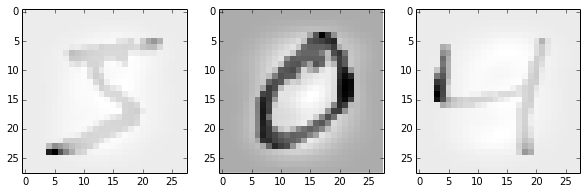

In [6]:
fig = plt.figure(figsize=(10,30))
for i in range(3):
    a=fig.add_subplot(1,3,(i+1))
    plt.imshow(-X[i,0,:,:], interpolation='none',cmap=plt.get_cmap('gray'))

Note that the backgound is not uniform. That is due to the batchnormalization.

### Our first simple network
Let's define a MLP. First we load the necessary libraries and then define the network. 
#### Definition of the network
There are several ways to define a network in Lasagne. We use the easiest method using the `NeuralNet` class from the `nolearn.lasagne` package. Other ways are detailed in the examples [https://github.com/Lasagne/Lasagne/blob/master/examples/]
 of the Lasagne library. 


In [7]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('hidden2', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    hidden1_num_units=500,
    hidden2_num_units=50,
    output_num_units=10, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=100,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

####Training of the net. 

After the definition of the network the network has to be trained. Therefore the data is split automatically into 80% training set and 20% test set (controlled by `eval_size=0.2`). We use the first 3000 samples as the training set.  

In [8]:
net = net1.fit(X[0:3000,:,:,:],y[0:3000])

  DenseLayer        	(None, 10)          	produces      10 outputs
  DenseLayer        	(None, 50)          	produces      50 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    1.663586  |    0.936631  |     1.776139  |     75.40%  |  0.1s
     2  |    0.576842  |    0.502766  |     1.147335  |     85.05%  |  0.1s
     3  |    0.325384  |    0.420501  |     0.773801  |     87.21%  |  0.1s
     4  |    0.225112  |    0.379367  |     0.593390  |     87.77%  |  0.1s
     5  |    0.166909  |    0.356527  |     0.468153  |     88.30%  |  0.1s
     6  |    0.128815  |    0.343567  |     0.374933  |     88.99%  |  0.1s
     7  |    0.102248  |    0.334965  |     0.305248  |     88.99%  |  0.1s
     8  |    0.082848  |    0.328473  |     0.2

/Library/Python/2.7/site-packages/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/Library/Python/2.7/site-packages/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "
/Library/Python/2.7/site-packages/lasagne/layers/base.py:99: UserWarning: layer.get_output_shape() is deprecated and will be removed for the first release of Lasagne. Please us

### Fitting procedure / log loss
The log-loss $J(\theta)$ is calculated for the training-set and validation set. It is defined as follows:
<img src="imgs/logloss.png" width="700"/>



It is plotted for each epoch below. An  epoch is defined by touching each member of the training set once.

   epoch  train_loss  valid_accuracy  valid_loss
0      1    1.663586        0.754035    0.936631
1      2    0.576842        0.850481    0.502766
2      3    0.325384        0.872064    0.420501
3      4    0.225112        0.877679    0.379367
4      5    0.166909        0.883001    0.356527
    epoch  train_loss  valid_accuracy  valid_loss
95     96    0.001534        0.907418    0.344858
96     97    0.001513        0.907418    0.345117
97     98    0.001492        0.907418    0.345367
98     99    0.001472        0.907418    0.345628
99    100    0.001453        0.907418    0.345879


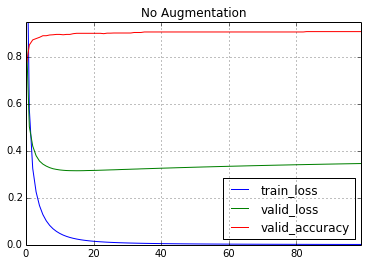

In [24]:
%matplotlib inline
import pandas as pd
df = pd.DataFrame(net.train_history_)
print(df.head())
print(df.tail())
df[['train_loss','valid_loss','valid_accuracy']].plot(title='No Augmentation', ylim=(0,0.95))

## Task 1 (evaluate the learning phase)
* What is the value of the log-loss for perfect classification?
* [optional] What is the value for the log-loss for random assignment to the classes?
* Describe the form of the curve

## Task 1 (LSG)
* 0 since log(1)=0
* For random assinment the probability for each class ist 1/10. So ln(1/10) = -2.3. Hence J = 2.3
* The training loss reaches the optimal value of 0 but the validation loss on the untouched validation set goes to goes up a again. This indicates overfitting to the training set.

## Task 2 (evaluate on testset)
Now that we have fixed the weights of the network, we can make predictions on unseen data 3000-4000 and evaluate the performance. You can use `net.predict`

In [21]:
np.mean(net.predict(X[3000:4000,:,:,:]) == y[3000:4000])

0.93200000000000005

## Misc
Note that the softmax layer assigns the following probabilities to the for the classes $i = 0,1,\ldots,9$ 

$
   p_i(\text{input image}) =  \frac{e^{z_i}}{\sum_{j=0}^9 e^{z_j}}
$

which he can obtain for a set of indices like via `net.predict_proba(X[toTest,:,:,:])`. The index with maximum probability is the predicted class and can be obtained by `net1.predict(X[toTest,:,:,:])`.

In [26]:
toTest = range(3001,3026) #Some indices we would like to have a look into
preds = net1.predict(X[toTest,:,:,:])
print(preds) #The predictions for the different classes 
print(net.predict_proba(X[toTest,:,:,:])[0:4]) #The probabilities from the softmax layer.
np.argmax(net.predict_proba(X[toTest,:,:,:])[0])

[0 2 8 1 3 2 5 7 4 9 8 0 3 9 0 0 2 4 1 9 0 9 2 0 5]
[[  9.99667883e-01   2.39569147e-08   7.26020471e-06   5.17028411e-06
    1.54214476e-07   2.07805224e-05   1.13834700e-04   1.51614386e-05
    1.57276707e-04   1.24506741e-05]
 [  4.69463666e-05   1.87159878e-06   8.57731581e-01   9.54737014e-04
    2.41198577e-04   1.04329432e-04   5.65963855e-04   8.45918804e-02
    4.86046448e-02   7.15682795e-03]
 [  2.50062886e-08   6.32122887e-09   2.57626397e-07   7.71577078e-08
    1.55390445e-09   1.14474688e-06   3.95410193e-09   2.44674792e-09
    9.99998450e-01   6.69706957e-09]
 [  2.19226567e-10   9.99982774e-01   3.44683038e-08   1.35299642e-05
    6.84515612e-07   2.37809289e-07   1.45426625e-07   5.36759295e-08
    1.87014493e-07   2.33020592e-06]]


0

####Let's look at the correponding images.
Shown is the predicted value and the true value in parenthesis.

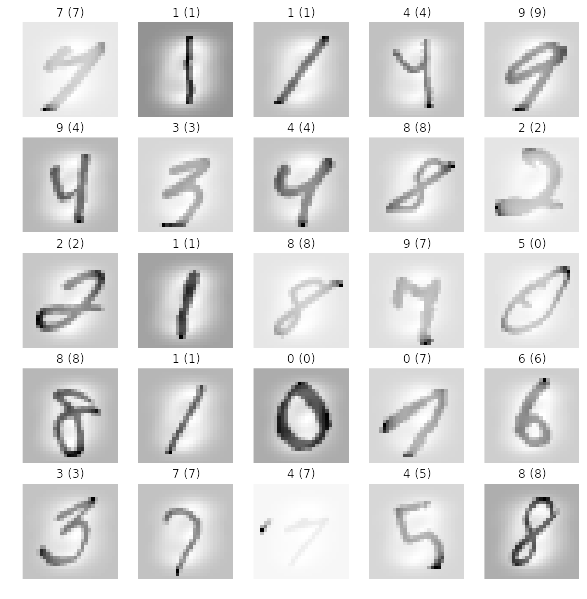

In [21]:
fig = plt.figure(figsize=(10,10))
for i,num in enumerate(toTest):
    a=fig.add_subplot(5,5,(i+1)) #NB the one based API sucks!
    plt.axis('off')
    a.set_title(str(preds[i]) + " (" + str(y[num]) + ")")
    plt.imshow(-X[num,0,:,:], interpolation='none',cmap=plt.get_cmap('gray'))

In the notebook [MinimalLasagneCNN.ipynb](MinimalLasagneCNN.ipynb) we show how to use a CNN.